In [157]:
# %pip install torch
# %pip install pyro-ppl
# %pip install cmocean

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from scipy import signal
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

In [3]:
# Fancy Rainbow colors on the plots
import cmocean
cmap = cmocean.cm.phase

def cart2pol(x, y):
    '''
    From cartesian to polar coordinates
    '''
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [32]:
#Mixing functions
def f_1(s):
    '''
    "Moderately nonlinear mixing"
    '''
    f0 = np.tanh(4*s[0] - 2) + s[0] + s[1]/2
    f1 = np.tanh(4*s[1] - 2) + s[1] + s[0]/2
    return np.array([f0, f1])

def f_2(s):
    '''
    "Rather nonlinear mixing"
    '''
    f0 = np.tanh(s[1])/2 + s[0] + s[0]**2/2
    f1 = s[0]**3 - s[0] + np.tanh(s[1])
    return np.array([f0, f1])

def f_3(s):
    '''
    "Non-bijective nonlinear mixing"
    '''
    f0 = s[1]**3 + s[0]
    f1 = np.tanh(s[1]) + s[0]**3
    return np.array([f0, f1])


In [33]:
#np.random.seed(0)
n_samples = 3000 #2000
time = np.linspace(0, 10, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
#s2 = np.sign(2 * time)  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s3]
S += 0.1 * np.random.normal(size=S.shape)  
min_val = np.min(S)
max_val = np.max(S)

S = (S - min_val) / (max_val - min_val) #Normalized
S -= 0.5

#Observations 

X = f_2(S.T).T

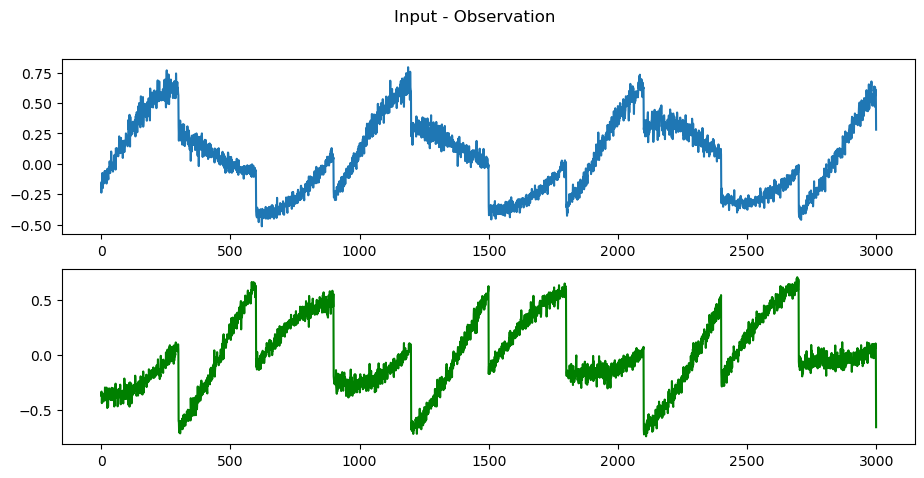

In [34]:
fig1, axs1 = plt.subplots(nrows=2, ncols=1, figsize=(11, 5))
axs1[0].plot(X[:,0])
axs1[1].plot(X[:,1],c='g')
fig1.suptitle('Input - Observation')
plt.show()

In [35]:
X = StandardScaler().fit_transform(X) #Normalized (0,1) 

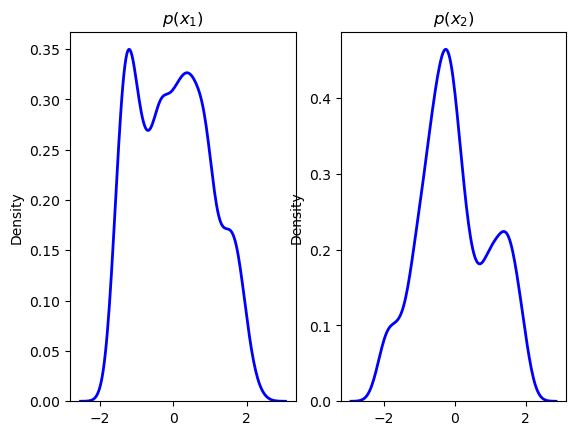

In [36]:
plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], color='blue', linewidth=2)
plt.title(r'$p(x_1)$')

plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], color='blue', linewidth=2)
plt.title(r'$p(x_2)$')

plt.show()

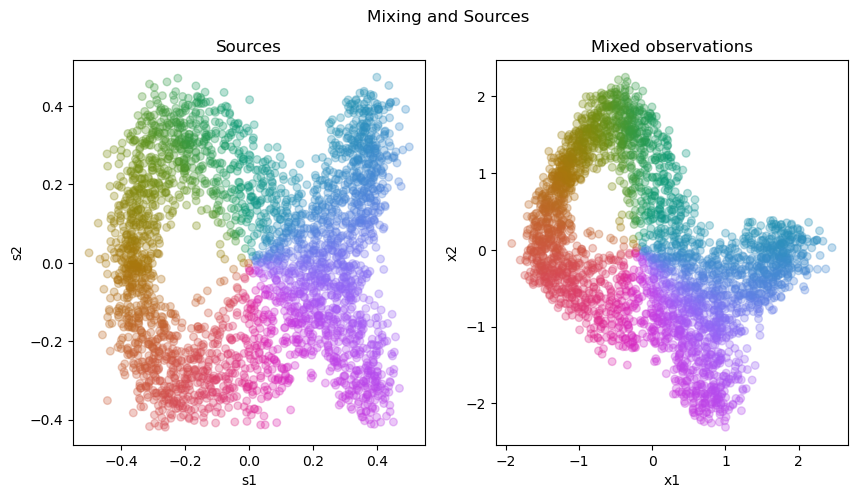

In [38]:
_, colors = cart2pol( S[:,0], S[:,1])

figc0, axsc0 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axsc0[0].scatter(S[:,0], S[:,1], c=colors, s=30, alpha=0.3, cmap=cmap)
axsc0[0].set_xlabel("s1")
axsc0[0].set_ylabel("s2")
axsc0[0].set_title("Sources")


axsc0[1].scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.3, cmap=cmap)
axsc0[1].set_xlabel("x1")
axsc0[1].set_ylabel("x2")
axsc0[1].set_title("Mixed observations")


figc0.suptitle('Mixing and Sources')
plt.show()

### **Pyro stratrs from here**

In [39]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [57]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()#Exact log likley
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.0829625129699707
step: 500, loss: 2.047572135925293
step: 1000, loss: 2.0371460914611816
step: 1500, loss: 2.0364794731140137
step: 2000, loss: 2.0295445919036865
step: 2500, loss: 2.0230422019958496
step: 3000, loss: 2.019606351852417
step: 3500, loss: 2.0242676734924316
step: 4000, loss: 2.018862009048462
step: 4500, loss: 2.015862464904785
step: 5000, loss: 2.0209732055664062
CPU times: user 4min 17s, sys: 779 ms, total: 4min 18s
Wall time: 1min 11s


In [41]:
flow_dist

TransformedDistribution()

In [42]:
torchinput = torch.tensor(X, dtype=torch.float)
torchinput.shape

torch.Size([3000, 2])

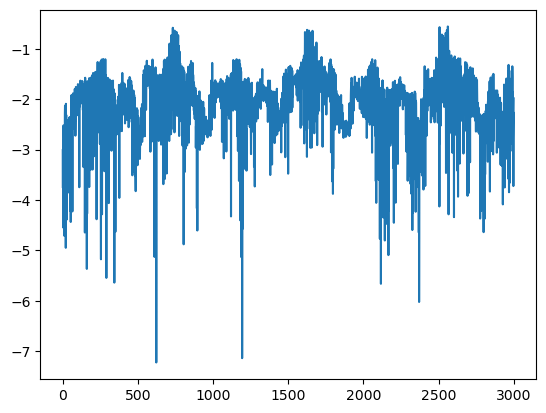

In [43]:
Joint_distro11 = flow_dist.log_prob(torchinput).detach()
Joint_distro11.shape #The Log Joint Distribution
plt.plot(Joint_distro11)

In [44]:
X_flow = flow_dist.sample(torch.Size([7000,])) #The estimated distribution over the data #sampling from the gaussian

# torchinput = X The Input

D_flow = (spline_transform(torchinput)).detach() #Forwards pass

D_flow_back = spline_transform.inv(D_flow)

D_flow = D_flow.detach().numpy()

D_flow_back = D_flow_back.detach().numpy()

D_flow_back_torch = D_flow_back

D_flow.shape

(3000, 2)

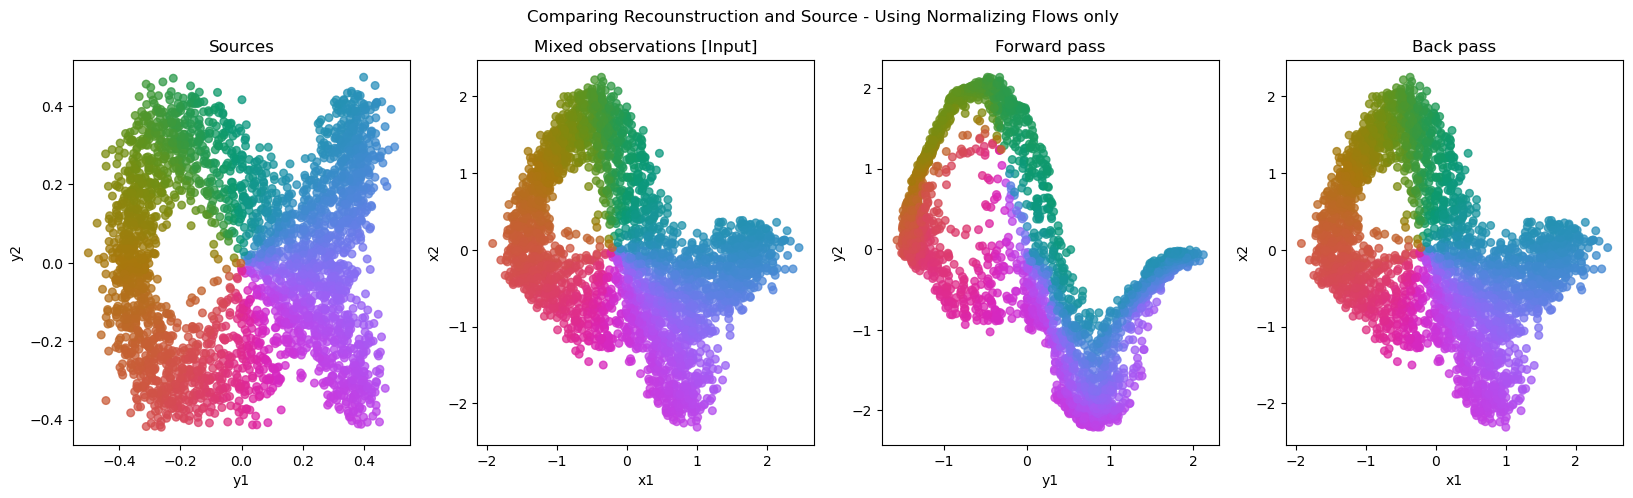

In [45]:
figc2, axsc2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

axsc2[0].scatter(S[:,0], S[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
axsc2[0].set_xlabel("y1")
axsc2[0].set_ylabel("y2")
axsc2[0].set_title("Sources")

axsc2[1].scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
axsc2[1].set_xlabel("x1")
axsc2[1].set_ylabel("x2")
axsc2[1].set_title("Mixed observations [Input]")

axsc2[2].scatter(D_flow[:,0], D_flow[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
axsc2[2].set_xlabel("y1")
axsc2[2].set_ylabel("y2")
axsc2[2].set_title("Forward pass")

axsc2[3].scatter(D_flow_back[:,0], D_flow_back[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)
axsc2[3].set_xlabel("x1")
axsc2[3].set_ylabel("x2")
axsc2[3].set_title("Back pass")



figc2.suptitle('Comparing Recounstruction and Source - Using Normalizing Flows only')
plt.show()

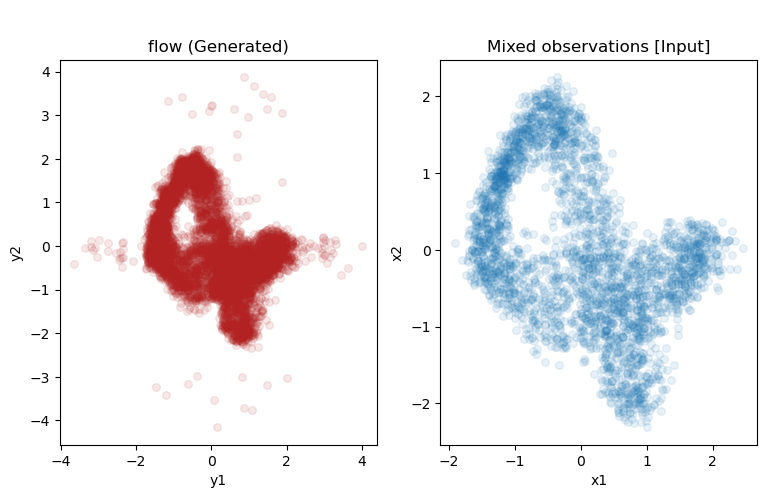

In [46]:
figlow, axslow = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axslow[0].scatter(X_flow[:,0], X_flow[:,1], s=30, alpha=0.1, color='firebrick')
axslow[0].set_xlabel("y1")
axslow[0].set_ylabel("y2")
axslow[0].set_title("flow (Generated)")

axslow[1].scatter(X[:,0], X[:,1], s=30, alpha=0.1)
axslow[1].set_xlabel("x1")
axslow[1].set_ylabel("x2")
axslow[1].set_title("Mixed observations [Input]")

figlow.suptitle(' ')
plt.show()

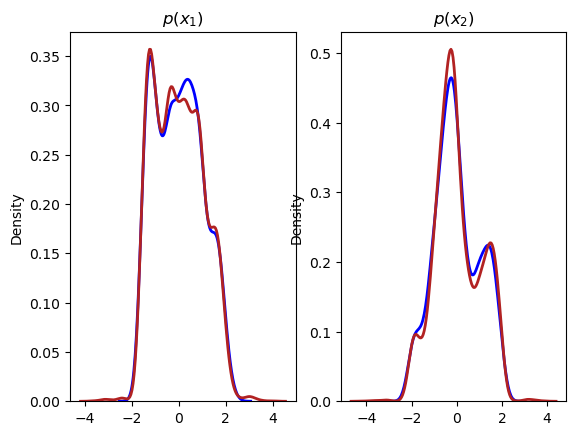

In [47]:
plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], color='blue', linewidth=2, label='data')
sns.kdeplot(X_flow[:,0], color='firebrick', linewidth=2, label='flow')
plt.title(r'$p(x_1)$')

plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], color='blue', linewidth=2, label='data')
sns.kdeplot(X_flow[:,1], color='firebrick', linewidth=2, label='flow')
plt.title(r'$p(x_2)$')

plt.show()

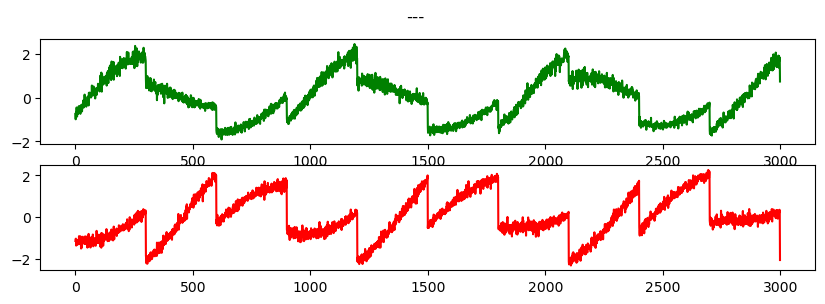

In [48]:
figrs, axrs = plt.subplots(nrows=2, ncols=1, figsize=(10, 3))
axrs[0].plot(D_flow_back[:,0],c='g')
#xrs[0].plot(X[:,0])

#axrs[0].set_title("Reconstructed source")
axrs[1].plot(D_flow_back[:,1],c='r')
#xrs[1].plot(X[:,1])
figrs.suptitle('---')
plt.show()  

**Even tho the Input data X is not tramsformed to some normal distriution (As in JAX - they use logistic dist. instead) - we can still do Normal CDF on the output to reconstruct the signal back**

In [51]:
def normal_cdf(x, mu, sigma):
    # Create a normal distribution with given mean (mu) and standard deviation (sigma)
    normal_dist = pyro.distributions.Normal(mu, sigma)
    # Evaluate the CDF on your input
    return normal_dist.cdf(x)

holdmybeer = torch.tensor(D_flow_back, dtype=torch.float)


Reconstructed_signals = normal_cdf(holdmybeer, torch.zeros(2), torch.ones(2)).detach().numpy() #Parameters that were used for the base normal distribution Z

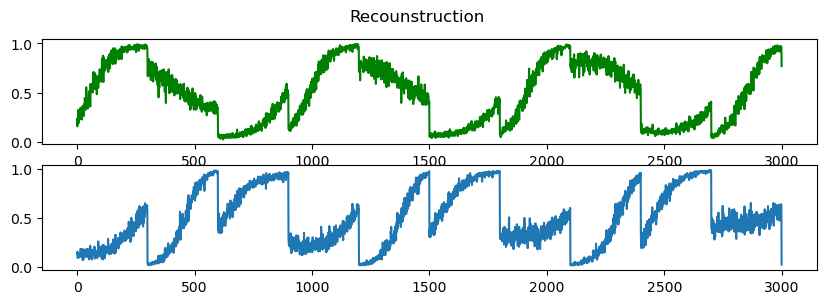

In [53]:
figrs, axrs = plt.subplots(nrows=2, ncols=1, figsize=(10, 3))
axrs[0].plot(Reconstructed_signals[:,0],c='g')
axrs[1].plot(Reconstructed_signals[:,1])

figrs.suptitle('Recounstruction')
plt.show()

### Generating Samples from the learnt function and distribution

In [54]:
# Forward pass (from base distribution to complex distribution)
sample_base_dist = base_dist.sample(torch.Size([3000,])) # We can sample as much as we need 
forward_samples = spline_transform(sample_base_dist)

# Inverse pass (from complex distribution to base distribution)
inverse_samples = spline_transform.inv(forward_samples)

forwardd = forward_samples.detach().numpy()
inversed = inverse_samples.detach().numpy()

In [55]:
forward_samples.shape

torch.Size([3000, 2])

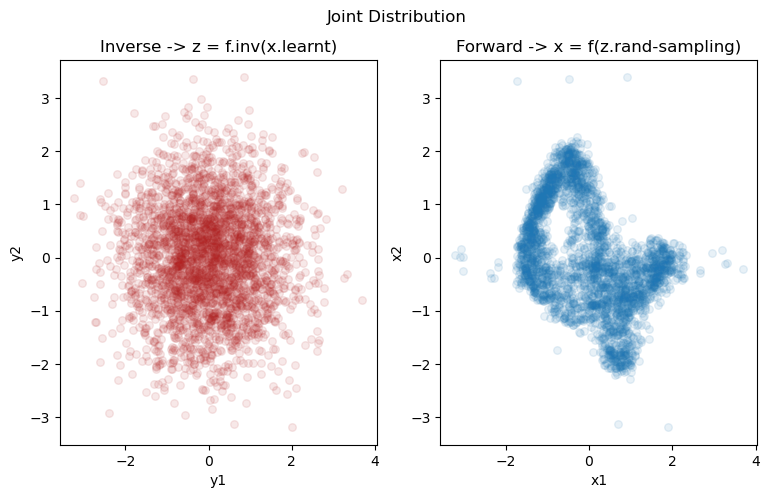

In [56]:
fignow, axsnow = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axsnow[0].scatter(inversed[:,0], inversed[:,1], s=30, alpha=0.1, color='firebrick')
axsnow[0].set_xlabel("y1")
axsnow[0].set_ylabel("y2")
axsnow[0].set_title("Inverse -> z = f.inv(x.learnt)")

axsnow[1].scatter(forwardd[:,0], forwardd[:,1], s=30, alpha=0.1)
axsnow[1].set_xlabel("x1")
axsnow[1].set_ylabel("x2")
axsnow[1].set_title("Forward -> x = f(z.rand-sampling)")

fignow.suptitle('Joint Distribution')
plt.show()